## Dynamic Risk Budgeting

In [58]:
idmport pandas as pd
import numpy as np
import risk_ as rk
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
n_scenarios = 5000
rates, zc_prices = rk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0=0.03, sigma=0.02)
price_eq = rk.gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15)

In [60]:
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = rk.bt_mix(rets_eq, rets_zc, allocator=rk.fixedmix_allocator, w1=0.7)
pd.concat([
    rk.terminal_stats(rets_eq, name="Equities", floor=0.75),
    rk.terminal_stats(rets_zc, name="FI", floor=0.75),
    rk.terminal_stats(rets_7030b, name="70/30", floor=0.75)
], axis=1).round(2)

,Equities,FI,70/30
mean,1.97,1.34,1.76
std,0.98,0.00,0.60
p_breach,0.04,NaN,0.01
e_short,0.13,NaN,0.08
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [61]:
def floor_allocator(psp_r, ghp_r, floor, zc_prices, m=3):
    """
    Allocate between PSP and GHP with the goal to provide exposure to the upside
    of the PSP without going violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple
    of the cushion in the PSP
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    """
    if zc_prices.shape != psp_r.shape:
        raise ValueError("PSP and ZC Prices must have the same shape")
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = floor*zc_prices.iloc[step] ## PV of Floor assuming today's rates and flat YC
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) # same as applying min and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        w_history.iloc[step] = psp_w
    return w_history

In [62]:
rets_floor75 = rk.bt_mix(rets_eq, rets_zc, allocator=rk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:])
pd.concat([
    rk.terminal_stats(rets_zc, name="FI", floor=0.75),
    rk.terminal_stats(rets_eq, name="Equities", floor=0.75),
    rk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
    rk.terminal_stats(rets_floor75, name="Floor75", floor=0.75)
], axis=1).round(2)

,FI,Equities,70/30,Floor75
mean,1.34,1.97,1.76,1.94
std,0.00,0.98,0.60,0.99
p_breach,NaN,0.04,0.01,NaN
e_short,NaN,0.13,0.08,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [63]:
rets_floor75m1 = rk.bt_mix(rets_eq, rets_zc, allocator=rk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=1)
rets_floor75m5 = rk.bt_mix(rets_eq, rets_zc, allocator=rk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=5)
pd.concat([
    rk.terminal_stats(rets_zc, name="FI", floor=0.75),
    rk.terminal_stats(rets_eq, name="Equities", floor=0.75),
    rk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
    rk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
    rk.terminal_stats(rets_floor75m1, name="Floor75 M1", floor=0.75),
    rk.terminal_stats(rets_floor75m5, name="Floor75 M5", floor=0.75),
], axis=1).round(7)

,FI,Equities,70/30,Floor75,Floor75 M1,Floor75 M5
mean,1.343337,1.966837,1.755011,1.943199,1.620657,1.952983
std,0.000000,0.982473,0.595989,0.987953,0.433569,0.990618
p_breach,NaN,0.035400,0.009400,NaN,NaN,NaN
e_short,NaN,0.133863,0.082045,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
rets_floor75m1 = rk.bt_mix(rets_eq, rets_zc, allocator=rk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=1)
rets_floor75m5 = rk.bt_mix(rets_eq, rets_zc, allocator=rk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=5)
pd.concat([
    rk.terminal_stats(rets_zc, name="FI", floor=0.75),
    rk.terminal_stats(rets_eq, name="Equities", floor=0.75),
    rk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
    rk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
    rk.terminal_stats(rets_floor75m1, name="Floor75 M1", floor=0.75),
    rk.terminal_stats(rets_floor75m5, name="Floor75 M5", floor=0.75),
], axis=1).round(2)

,FI,Equities,70/30,Floor75,Floor75 M1,Floor75 M5
mean,1.34,1.97,1.76,1.94,1.62,1.95
std,0.00,0.98,0.60,0.99,0.43,0.99
p_breach,NaN,0.04,0.01,NaN,NaN,NaN
e_short,NaN,0.13,0.08,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


# Risk Budgeting with Drawdown Constraints

In [65]:
# All done with simulated data, use real data (create an ETL function t o pull in historic prices)
cashrate = 0.02
monthly_cashreturn = (1 + cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = rk.bt_mix(rets_eq, rets_cash, allocator=rk.drawdown_allocator, maxdd=.25)
tv_maxdd25 = rk.terminal_values(rets_maxdd25)
pd.concat([
    rk.terminal_stats(rets_zc, name="FI", floor=0.75),
    rk.terminal_stats(rets_eq, name="Equities", floor=0.75),
    rk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
    rk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
    rk.terminal_stats(rets_floor75m1, name="Floor75 M1", floor=0.75),
    rk.terminal_stats(rets_floor75m5, name="Floor75 M5", floor=0.75),
    rk.terminal_stats(rets_maxdd25, name="Maxdd25", floor=0.75),
], axis=1).round(4)

,FI,Equities,70/30,Floor75,Floor75 M1,Floor75 M5,Maxdd25
mean,1.3433,1.9668,1.7550,1.9432,1.6207,1.9530,1.6276
std,0.0000,0.9825,0.5960,0.9880,0.4336,0.9906,0.5405
p_breach,NaN,0.0354,0.0094,NaN,NaN,NaN,NaN
e_short,NaN,0.1339,0.0820,NaN,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
rk.summary_stats(rets_maxdd25)["Max Drawdown"].head()

0   -0.204064
1   -0.181439
2   -0.160843
3   -0.183151
4   -0.176543
Name: Max Drawdown, dtype: float64

In [67]:
rk.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.2353397903725082

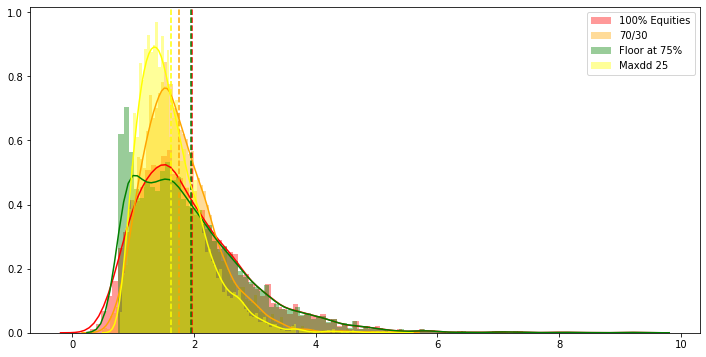

In [70]:
tv_eq = rk.terminal_values(rets_eq)
tv_zc = rk.terminal_values(rets_zc)
tv_7030b = rk.terminal_values(rets_7030b)
tv_floor75 = rk.terminal_values(rets_floor75)
tv_maxdd25 = rk.terminal_values(rets_maxdd25)
# plot
plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
sns.distplot(tv_7030b, color="orange", label="70/30", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.distplot(tv_maxdd25, color="yellow", label="Maxdd 25", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")n 
plt.legend();

# Drawdown Constraint with Historical Data

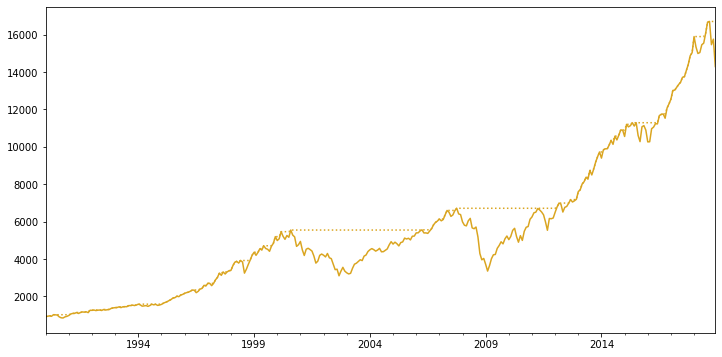

In [75]:
rets_tmi = rk.get_total_market_index_returns()["1990":]
dd_tmi = rk.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(12, 6), ls="-", color="goldenrod")
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")

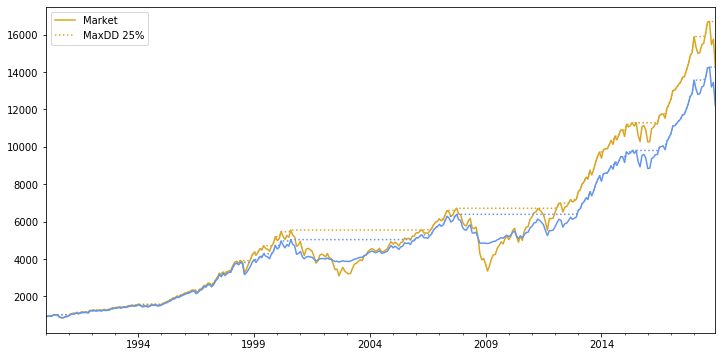

In [84]:
# using historical data (rets_tmi) as opposed to simulated EQ dwith with rets_eq for r1
cashrate = 0.03
monthly_cashreturn = (1 + cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe
rets_maxdd25 = rk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=rk.drawdown_allocator, maxdd=.25, m=5)
dd_25 = rk.drawdown(rets_maxdd25[0])

ax = dd_tmi["Wealth"].plot(figsize=(12, 6), ls="-", color="goldenrod", label="Market", legend=True)
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25["Previous Peak"].plot(ax=ax, color="cornflowerblue", ls=":")

In [88]:
rk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxDD")], axis=1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.066949,0.094633,0.441951,-0.499943
MaxDD,0.090062,0.112755,-0.630463,5.015334,0.049978,0.071074,0.518327,-0.244212
